In [1]:
#!/usr/bin/env python
# -*- coding: utf-8 -*-


# Deep Neural Networks

## Session 05b
### Neural Network with :
- One hidden layer 
- ${Tanh}$ activation function
- multi-class - Fashion MNIST dataset (all 60000 images)


<img src='../../images/prasami_color_tutorials_small.png' width='400' alt="By Pramod Sharma : pramod.sharma@prasami.com" align="left"/>

In [2]:
# Lets import some libraries
import os

import torch
#import numpy as np

import pandas as pd

import matplotlib.pyplot as plt

from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, ConfusionMatrixDisplay

import time

%matplotlib inline

In [3]:
# Some basic parameters
inpDir = '../input'
outDir = '../output'
modelDir = '../models'
modelSubDir = 'pytorch_fashion'

RANDOM_STATE = 24

torch.manual_seed(RANDOM_STATE) # Set Random Seed for reproducible  results

EPOCHS = 15001 # number of epochs
ALPHA = 0.1 # learning rate
NUM_BATCHES = 6 # How many samples we want to generate 
NOISE = 0.2 # Noise to be introduced in the data
TEST_SIZE = 0.2

# parameters for Matplotlib
params = {'legend.fontsize': 'x-large',
          'figure.figsize': (15, 10),
          'axes.labelsize': 'x-large',
          'axes.titlesize':'x-large',
          'xtick.labelsize':'x-large',
          'ytick.labelsize':'x-large'
         }

CMAP = 'brg' # 

plt.cm.Spectral

plt.rcParams.update(params)

## Generate Data Set
<p style="font-family: Arial; font-size:1.1em;color:blue;">
Loading Fashion MNIST Dataset
</p>

In [4]:
train_filename = os.path.join(inpDir, 'fashion_mnist', 'fashion-mnist_train.csv')
test_filename = os.path.join(inpDir, 'fashion_mnist', 'fashion-mnist_test.csv')

train_df = pd.read_csv(train_filename, header = 0)
test_df = pd.read_csv(test_filename, header = 0)

In [5]:
y_train = train_df.label.to_numpy()
X_train = train_df.drop('label', axis = 1).to_numpy()

y_test = test_df.label.to_numpy()
X_test = test_df.drop('label', axis = 1).to_numpy()

In [6]:
# Normalize pixel values to be between 0 and 1
X_train = X_train / 255.0
X_test = X_test / 255.0

In [7]:
labels= {0 : 'T-shirt/top',
         1  : 'Trouser',
         2  : 'Pullover',
         3 : 'Dress',
         4 : 'Coat',
         5 : 'Sandal',
         6 : 'Shirt',
         7 : 'Sneaker',
         8 : 'Bag',
         9 : 'Ankle boot'}


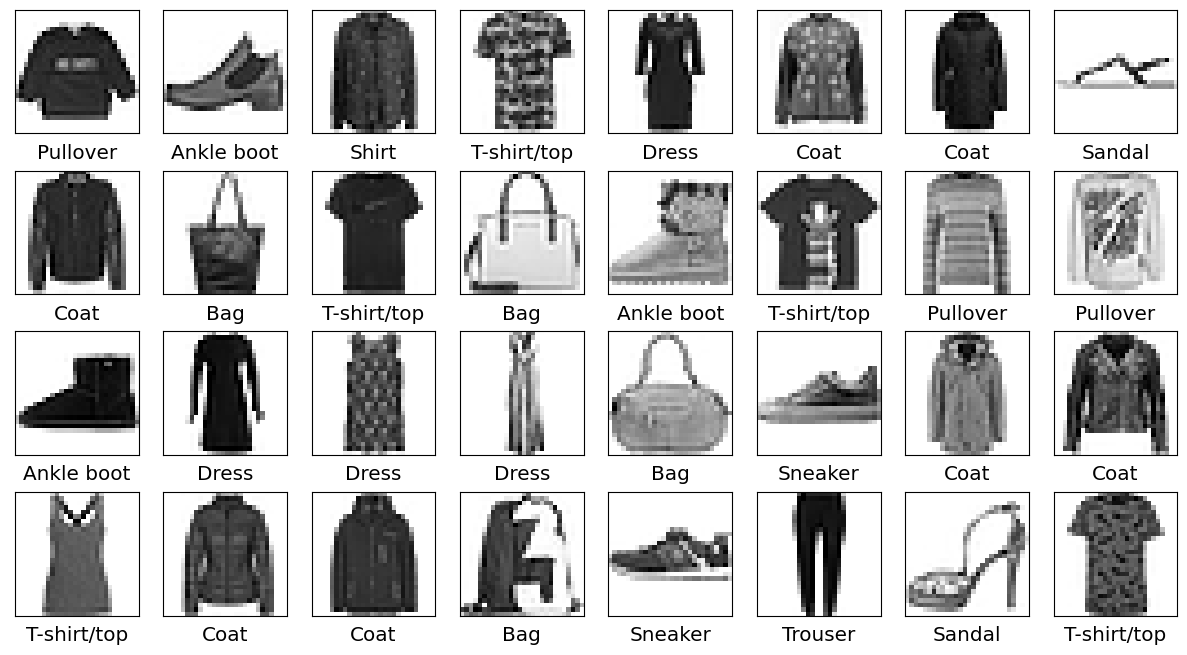

In [8]:
plt.figure(figsize=(15,8))
for i in range(32):
    plt.subplot(4,8,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(X_train[i].reshape(28,28,1), cmap=plt.cm.binary)
    plt.xlabel(labels[y_train[i]])
plt.show()

In [9]:
y_train = pd.get_dummies(y_train).values
y_train.shape

(60000, 10)

In [10]:
y_test = pd.get_dummies(y_test).values
y_test.shape

(10000, 10)

In [11]:
# Converting to Tensor...
# For faster run reduce training examples
X_train_tensor = torch.tensor(X_train).cuda()
#X_train_tensor = torch.tensor(X_train[:10000]).cuda()
X_test_tensor = torch.tensor(X_test).cuda()

y_train_tensor = torch.tensor(y_train).cuda()
#y_train_tensor = torch.tensor(y_train[:10000]).cuda()
y_test_tensor = torch.tensor(y_test).cuda()

In [12]:
28*28

784

In [13]:
X_train_tensor.shape

torch.Size([60000, 784])

## Activation Functions

### Softmax Function


$\sigma(z_i) = \dfrac{e^{(z_i)}}{\sum_{j=1}^{K}e^{z_j}}$


In [14]:
def fn_softmax(z):
    
    exp_sc = torch.exp(z)
    
    return exp_sc / torch.sum( exp_sc, dim = 1, keepdim= True)    

In [15]:
sm = fn_softmax(torch.tensor([[8, 5, 0]]))
print (sm)

tensor([[9.5227e-01, 4.7411e-02, 3.1945e-04]])


In [16]:
sm = fn_softmax(torch.tensor([[-10, 0., 10]]))
print (sm)

tensor([[2.0611e-09, 4.5398e-05, 9.9995e-01]])


### Other Activation Function

In [17]:
def fn_activ(x):

    return torch.tanh(x)

def fn_activ_prime(x):

    return 1.0 - torch.tanh(x)**2

### Is ourActivation Function working?

In [18]:
torch.tanh(torch.tensor(0.5))

tensor(0.4621)

In [19]:
(1 - torch.float_power(torch.tanh(torch.tensor(0.5)), 2))

tensor(0.7864, dtype=torch.float64)

In [20]:
fn_activ_prime(torch.tensor(0.5))

tensor(0.7864)

## Loss Function

We need to minimize the error by adjusting ($Ws, bs$). We call the function that measures our error the <b>loss function</b>. A common choice with the sigmoid output is the cross-entropy loss. The loss for predictions $\hat{y}$ with respect to the true labels $y$ is given by:

$
\begin{aligned}
L(\hat{y_i}, y_i) =  -[y_i.log\hat{y_i} + (1 - y_i) . log(1-\hat{y_i})]
\end{aligned}
$

For all samples:

$
\begin{aligned}
J(\hat{y}, y) =  -\frac{1}{m}\sum_{i=1}^{m}[y_i.log\hat{y}_i + (1-y_i) . log(1-\hat{y}_i)]
\end{aligned}
$


We can use gradient descent to find its minimum. For purpose of this Session, let's use it in its simplest form - <b>batch gradient descent with fixed learning rate</b>.

### Loss Function

In [21]:
# Helper function to evaluate the total loss on the dataset

def calculate_loss(model, X, y):
    '''
    Args:
        model: dictionay object containing weights and biases
        X: Feature Matrix
        y: Labels array
    Returns:
        Average loss
    '''
    
    # extract weights and losses from the model
    W1, b1, W2, b2 = model['W1'], model['b1'], model['W2'], model['b2']
    
    # Forward propagation to calculate our predictions
    # Layer 1
    z1 = torch.matmul(X, W1) + b1
    
    # Activation
    a1 = fn_activ(z1)
    
    # Layer 2
    z2 = torch.matmul(a1, W2) + b2
    
    # sigmoid  activation
    a2 = fn_softmax(z2)
    
    # Calculating the loss
    data_loss = -(y * torch.log(a2) + (1 - y) * torch.log(1 - a2)).sum() # 

    return 1./num_examples * data_loss

## Predict Function

For predictions, we will simply be using the forward propagation. No need to iterate or calculate the back propagation for supervised learning.


In [22]:
# Helper function to predict an output (0 or 1)

def predict(model, X):
    '''
     Args:
         model
         X: input features
    Returns:
        Predictions against the instances
         
    '''
    
    X = X.float().cuda()
    
    W1, b1, W2, b2 = model['W1'], model['b1'], model['W2'], model['b2']
    
    # Layer 1
    z1 = torch.matmul(X, W1) + b1
    
    # Activation
    a1 = fn_activ(z1)
    
    # Layer 2
    z2 = torch.matmul(a1, W2) + b2
    
    # sigmoid  activation
    a2 = fn_softmax(z2)
    
    return torch.argmax(a2, axis =1) # pick with one with highest probabilities

## Back-propagation for all Rows
For all rows, equations will remain same and the values will be divided by <b><i>'m'</i></b>; number of samples.

$
\begin{aligned}
\partial{z^{[2]}}  & = a^{[2]} - y  \\
\partial{W^{[2]}}  & = \frac{1}{m} a^{[1]T}\circ \partial{z^{[2]}} \\
\partial{b^{[2]}}  & = \frac{1}{m} \mathrm{np.sum}(\partial{z^{[2]}}, axis = 0, keepdims = True) \\
\\
\partial{z^{[1]}}  & = \partial{z^{[2]}}\circ  W^{[2]T} * ( 1-a^{[1]}**2)\\
\partial{W^{[1]}}  & = \frac{1}{m} X^{T}\circ \partial{z^{[1]}} \\
\partial{b^{[1]}}  & = \frac{1}{m} \mathrm{np.sum}(\partial{z^{[1]}}, axis = 0, keepdims = True) \\
\\
\end{aligned}
$

## Prepare Model:

In [23]:
def build_model(nn_hdim, X, y, 
                epochs = EPOCHS, 
                alpha = ALPHA,
                print_loss=False):
    
    '''
    Args:
        nn_hdim : Number of nodes in the hidden layer
        X : Training features to train
        y : Trainig targets (labels)
        epochs : Number of passes through the training data for gradient descent
        alpha : learning rate
        print_loss : If True, print the loss every nnn iterations
        
    Returns:
        Model: Dictionary object containing weights and biases
    '''
    
    # Initialize the parameters to random values. We need to learn these.
    # Weights
    W1 = torch.rand(nn_input_dim, nn_hdim) / torch.sqrt(torch.tensor(nn_input_dim))
    W2 = torch.rand(nn_hdim, nn_output_dim) / torch.sqrt(torch.tensor(nn_hdim))
    # Bias
    b1 = torch.zeros((1, nn_hdim))
    b2 = torch.zeros((1, nn_output_dim))
    
    W1 = W1.cuda()
    W2 = W2.cuda()
    b1 = b1.cuda()
    b2 = b2.cuda()
    
    
    X = X.float().cuda()
    y = y.float().cuda()
    curr_loss = 0
    loss = []
    epoch = []
    
    #Keeping track of time
    start_time = time.time()
    
    # Gradient descent. For each batch...
    for i in range(0, epochs):
        
        epoch_time = time.time()
        
        ##########################
        #   Forward propagation  #
        ##########################
        
        # Layer 1
        z1 = torch.matmul(X, W1) + b1
    
        # Activation
        a1 = fn_activ(z1)
    
        # Layer 2
        z2 = torch.matmul(a1, W2) + b2
    
        # sigmoid  activation
        a2 = fn_softmax(z2)

        #######################
        #   Back propagation  #
        #######################
        # Layer 2
        dz2 = a2-y

        dW2 = torch.matmul(torch.t(a1), dz2)
        assert(W2.shape == dW2.shape), 'Shape of W2 {} and dW2 {} do not match'.format(W2.shape, dW2.shape)
        
        db2 = torch.sum(dz2, dim=0, keepdim=True) # db2 is sum along axis 0  
        assert(b2.shape == db2.shape), 'Shape of b2 {} and db2 {} do not match'.format(b2.shape, db2.shape)
            
        dz1 = torch.matmul(dz2, torch.t(W2)) * fn_activ_prime(z1)  #derivative of Activation Function
        #                                        '*' indicates element wise multiplication
        assert(z1.shape == dz1.shape), 'Shape of z1 {} and dz1 {} do not match'.format(W2.shape, dW2.shape)
        
        dW1 = torch.matmul( torch.t(X), dz1)
        assert(W1.shape == dW1.shape), 'Shape of W1 {} and dW1 {} do not match'.format(W1.shape, dW1.shape)
        db1 = torch.sum(dz1, dim=0, keepdim=True) 
        assert(b1.shape == db1.shape), 'Shape of b1 {} and db1 {} do not match'.format(b1.shape, db1.shape)
        
        # Gradient descent parameter update
        W1 += -alpha * dW1/num_examples
        b1 += -alpha * db1/num_examples
        W2 += -alpha * dW2/num_examples
        b2 += -alpha * db2/num_examples
        
        # Assign new parameters to the model
        # Model as a Dict object to be return
        model = { 'W1': W1, 'b1': b1, 'W2': W2, 'b2': b2}
        
        if i % 100:
            curr_loss = calculate_loss(model, X, y)
            loss.append(curr_loss.cpu().item())
            epoch.append(i)
        
        # Print the loss.
        if print_loss and i % 1000 == 0:
            print('Loss after iteration {:d} : {:.5f}'.format(i, curr_loss))
            
            print ('Time take in last epoch {:.3f} Sec'.format(time.time()-epoch_time))
    
    print ('#### Overall time taken since begining {:.3f} Mins'.format((time.time()-start_time)/60.))
    
    return model, epoch, loss

In [24]:
num_examples = len(X_train) # training set size
nn_input_dim = 784 # input layer dimensionality
nn_output_dim = 10 # output layer dimensionality

# lists to facilitate plotting 
loss_hist = {}

In [25]:
#y_train = y_train.reshape(-1,1)
y_train_tensor.shape

torch.Size([60000, 10])

In [26]:
modelFilePath = os.path.join(modelDir, modelSubDir, 'model.pt')

In [27]:
784//4

196

In [ ]:
if os.path.exists(modelFilePath):
    print (f'model exists at {modelFilePath}...loading...')
    model = torch.load(modelFilePath)
    trainModel = False
else:
    print (f'Model not found at {modelFilePath}... Training!!')
    trainModel = True
    # Build a model with a hidden layer
    model, epoch, loss = build_model(784//4, X_train_tensor, y_train_tensor,
                                 epochs = EPOCHS, 
                                 alpha = ALPHA, 
                                 print_loss=True)
    torch.save( model, os.path.join(modelFilePath) )

Model not found at ../models/pytorch_fashion/model.pt... Training!!
Loss after iteration 0 : 0.00000
Time take in last epoch 0.253 Sec


In [ ]:
model

In [ ]:
if trainModel:
    loss_hist = {'epoch': epoch, 'loss' : loss}

    loss_df = pd.DataFrame(loss_hist)

    fig, axes = plt.subplots(1,2 , figsize = (15,6))

    l_range = len(loss_df) //10

    ax = axes[0]

    loss_df.plot(x = 'epoch', y = 'loss', ax = ax)
    loss = loss_df['loss'].values

    # little beautification
    txtstr = "Errors: \n  Start : {:7.4f}\n   End : {:7.4f}".format(loss[0],loss[-1]) #text to plot
    # properties  matplotlib.patch.Patch 
    props = dict(boxstyle='round', facecolor='wheat', alpha=0.5)

    # place a text box in upper left in axes coords

    ax.text(0.6, 0.95, txtstr, transform=ax.transAxes, fontsize=14,
            verticalalignment='top', bbox=props)

    ax.set_xlabel("Epochs")
    ax.set_ylabel("Error")
    ax.set_title('Overall')
    ax.grid();

    ax = axes[1]

    loss_df[-l_range:].plot(x = 'epoch', y = 'loss', ax = ax)

    # little beautification
    txtstr = "Errors: \n  Start : {:7.4f}\n   End : {:7.4f}".format(loss[-l_range],loss[-1]) #text to plot
    # properties  matplotlib.patch.Patch 
    props = dict(boxstyle='round', facecolor='wheat', alpha=0.5)

    # place a text box in upper left in axes coords

    ax.text(0.6, 0.95, txtstr, transform=ax.transAxes, fontsize=14,
            verticalalignment='top', bbox=props)

    ax.set_xlabel("Epochs")
    ax.set_ylabel("Error")
    ax.set_title('Last {} records'.format(l_range))
    ax.grid();
    plt.tight_layout()

In [ ]:
y_pred = predict(model, X_train_tensor).cpu()
y_train = torch.argmax(y_train_tensor, axis =1).cpu()
print('Accuracy score on Train Data :', accuracy_score(y_train, y_pred))

In [ ]:
print(classification_report(y_train, y_pred))

In [ ]:
y_pred = predict(model, X_test_tensor).cpu()

y_test = torch.argmax(y_test_tensor, axis =1).cpu()

print('Accuracy score on Train Data :', accuracy_score(y_test, y_pred))

In [ ]:
print(classification_report(y_test, y_pred))

In [ ]:
cm  = confusion_matrix(y_test, y_pred)
cm

In [ ]:
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels.values())

fig, ax = plt.subplots(figsize = (8,8))

disp.plot(ax = ax, cmap = 'Blues', colorbar=False, xticks_rotation='vertical')
plt.show();

In [ ]:
y_test_plot = test_df.label.to_numpy()

plt.figure(figsize=(15,9))
for i in range(28):
    plt.subplot(4,7,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(X_test[i].reshape(28,28,1), cmap=plt.cm.binary)
    plt.xlabel(labels[y_test_plot[i]]+'/'+labels[y_pred[i].item()])
plt.tight_layout()
plt.show()